In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras_tuner import HyperModel, Hyperband

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

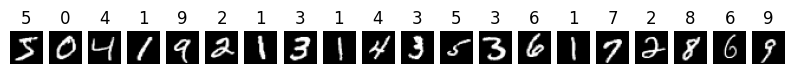

In [ ]:
# Visualize some samples from the dataset
def plot_samples(x, y, num_samples=20):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x[i], cmap='gray')
        plt.title(np.argmax(y[i]))
        plt.axis('off')
    plt.show()

plot_samples(x_train[:100], y_train[:100])

In [ ]:
# Split validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [ ]:
# Reshape data for different models
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test_cnn = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train_rnn = x_train.reshape(x_train.shape[0], 28, 28)
x_val_rnn = x_val.reshape(x_val.shape[0], 28, 28)
x_test_rnn = x_test.reshape(x_test.shape[0], 28, 28)


In [ ]:
### RNN Model
def build_rnn_model():
    model = Sequential([
        SimpleRNN(128, input_shape=(28, 28), activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_history = rnn_model.fit(x_train_rnn, y_train, epochs=10, batch_size=128, validation_data=(x_val_rnn, y_val))
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(x_test_rnn, y_test)

Epoch 1/10
422/422 [==============================] - 12s 26ms/step - loss: 0.6086 - accuracy: 0.8009 - val_loss: 0.2331 - val_accuracy: 0.9333
Epoch 2/10
422/422 [==============================] - 9s 22ms/step - loss: 0.2095 - accuracy: 0.9376 - val_loss: 0.2074 - val_accuracy: 0.9385
Epoch 3/10
422/422 [==============================] - 10s 23ms/step - loss: 0.1563 - accuracy: 0.9539 - val_loss: 0.1188 - val_accuracy: 0.9652
Epoch 4/10
422/422 [==============================] - 13s 30ms/step - loss: 0.1340 - accuracy: 0.9606 - val_loss: 0.1100 - val_accuracy: 0.9677
Epoch 5/10
422/422 [==============================] - 10s 24ms/step - loss: 0.1189 - accuracy: 0.9647 - val_loss: 0.1089 - val_accuracy: 0.9690
Epoch 6/10
422/422 [==============================] - 10s 24ms/step - loss: 0.1050 - accuracy: 0.9693 - val_loss: 0.1229 - val_accuracy: 0.9655
Epoch 7/10
422/422 [==============================] - 8s 20ms/step - loss: 0.1045 - accuracy: 0.9698 - val_loss: 0.1080 - val_accuracy: 0

In [ ]:
### CNN Model with Hyperparameter Tuning
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(Conv2D(
                filters=hp.Int('filters_' + str(i), 32, 128, step=32),
                kernel_size=hp.Choice('kernel_size_' + str(i), [3, 5]),
                activation='relu',
                input_shape=(28, 28, 1)
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(Dense(
                units=hp.Int('units_' + str(i), 32, 128, step=32),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
        model.add(Dense(10, activation='softmax'))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
tuner_cnn = Hyperband(
    CNNHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)


Reloading Tuner from my_dir/cnn_tuning/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_cnn.search(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val), callbacks=[stop_early])
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
cnn_model = tuner_cnn.hypermodel.build(best_hps_cnn)
cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val))
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_cnn, y_test)

Epoch 1/10
1688/1688 [==============================] - 109s 64ms/step - loss: 0.8771 - accuracy: 0.7028 - val_loss: 0.1723 - val_accuracy: 0.9538
Epoch 2/10
 247/1688 [===>..........................] - ETA: 1:35 - loss: 0.3735 - accuracy: 0.8923

KeyboardInterrupt: 

In [ ]:
# best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
# cnn_model = tuner_cnn.hypermodel.build(best_hps_cnn)
# cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val))
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_cnn, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.2172 - accuracy: 0.9302


In [ ]:
### LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(128, input_shape=(28, 28), activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_history = lstm_model.fit(x_train_rnn, y_train, epochs=10, batch_size=128, validation_data=(x_val_rnn, y_val))
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(x_test_rnn, y_test)


Epoch 1/10
422/422 [==============================] - 35s 79ms/step - loss: 0.7006 - accuracy: 0.7688 - val_loss: 0.1960 - val_accuracy: 0.9392
Epoch 2/10
422/422 [==============================] - 30s 70ms/step - loss: 0.1652 - accuracy: 0.9481 - val_loss: 0.1227 - val_accuracy: 0.9582
Epoch 3/10
422/422 [==============================] - 30s 71ms/step - loss: 0.1155 - accuracy: 0.9647 - val_loss: 0.1005 - val_accuracy: 0.9713
Epoch 4/10
422/422 [==============================] - 30s 71ms/step - loss: 0.0902 - accuracy: 0.9717 - val_loss: 0.0827 - val_accuracy: 0.9752
Epoch 5/10
422/422 [==============================] - 31s 74ms/step - loss: 0.0813 - accuracy: 0.9748 - val_loss: 0.0694 - val_accuracy: 0.9792
Epoch 6/10
422/422 [==============================] - 30s 71ms/step - loss: 0.0687 - accuracy: 0.9792 - val_loss: 0.0551 - val_accuracy: 0.9838
Epoch 7/10
422/422 [==============================] - 33s 78ms/step - loss: 0.0610 - accuracy: 0.9811 - val_loss: 0.0683 - val_accuracy:

In [ ]:
### LSTM-CNN Hybrid Model with Hyperparameter Tuning
class LSTMCNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(Conv2D(
                filters=hp.Int('filters_' + str(i), 32, 128, step=32),
                kernel_size=hp.Choice('kernel_size_' + str(i), [3, 5]),
                activation='relu',
                input_shape=(28, 28, 1)
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, activation='relu'))
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(Dense(
                units=hp.Int('units_' + str(i), 32, 128, step=32),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
        model.add(Dense(10, activation='softmax'))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
tuner_lstm_cnn = Hyperband(
    LSTMCNNHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='lstm_cnn_tuning'
)

Reloading Tuner from my_dir/lstm_cnn_tuning/tuner0.json


In [ ]:
tuner_lstm_cnn.search(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val), callbacks=[stop_early])
best_hps_lstm_cnn = tuner_lstm_cnn.get_best_hyperparameters(num_trials=1)[0]
# lstm_cnn_model = tuner_lstm_cnn.hypermodel.build(best_hps_lstm_cnn)
# lstm_cnn_history = lstm_cnn_model.fit(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val))
# lstm_cnn_test_loss, lstm_cnn_test_acc = lstm_cnn_model.evaluate(x_test_cnn, y_test)

Epoch 1/10
1688/1688 [==============================] - 162s 95ms/step - loss: 0.3295 - accuracy: 0.8948 - val_loss: 0.1115 - val_accuracy: 0.9663
Epoch 2/10
1688/1688 [==============================] - 156s 93ms/step - loss: 0.0973 - accuracy: 0.9697 - val_loss: 0.0760 - val_accuracy: 0.9793
Epoch 3/10
 978/1688 [================>.............] - ETA: 1:06 - loss: 0.0669 - accuracy: 0.9794

In [ ]:
lstm_cnn_model = tuner_lstm_cnn.hypermodel.build(best_hps_lstm_cnn)
lstm_cnn_history = lstm_cnn_model.fit(x_train_cnn, y_train, epochs=10, validation_data=(x_val_cnn, y_val))
lstm_cnn_test_loss, lstm_cnn_test_acc = lstm_cnn_model.evaluate(x_test_cnn, y_test)

NameError: name 'best_hps_lstm_cnn' is not defined

In [ ]:

lstm_cnn_test_loss, lstm_cnn_test_acc = lstm_cnn_model.evaluate(x_test_cnn, y_test)

NameError: name 'lstm_cnn_model' is not defined

In [ ]:
### Compare Results
print(f'RNN Test Accuracy: {rnn_test_acc*100}')
print(f'CNN Test Accuracy: {cnn_test_acc*100}')
print(f'LSTM Test Accuracy: {lstm_test_acc*100}')
print(f'LSTM-CNN Hybrid Test Accuracy: {lstm_cnn_test_acc*100}')

RNN Test Accuracy: 97.42000102996826


NameError: name 'cnn_test_acc' is not defined

In [ ]:
### Plot Validation Curves
def plot_validation_curves(histories, labels):
    plt.figure(figsize=(12, 8))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({label})')
    plt.title('Validation Accuracy for Different Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_validation_curves([rnn_history, cnn_history, lstm_history, lstm_cnn_history], ['RNN', 'CNN', 'LSTM', 'LSTM-CNN Hybrid'])

In [ ]:

### Comparison Graph for Final Accuracies
models = ['RNN', 'CNN', 'LSTM', 'LSTM-CNN Hybrid']
test_accuracies = [rnn_test_acc, cnn_test_acc, lstm_test_acc, lstm_cnn_test_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.title('Comparison of Test Accuracies')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0.9, 1.0)
plt.show()